In [3]:
library(DESeq2)
library(ggplot2)
library(clusterProfiler)
library(biomaRt)
library(ReactomePA)
library(DOSE)
library(KEGG.db)
library(org.Hs.eg.db)
library(pheatmap)
library(genefilter)
library(RColorBrewer)
library(GO.db)
library(topGO)
library(dplyr)
library(gage)
library(ggsci)

In [5]:
data <- read.table("final_counts.txt", header = TRUE, skip = 1, row.names = 1)
#head(data)
data <- data[,c(-1:-5)]
colnames(data) <- gsub("_21.bam", "", colnames(data), fixed = T)
colnames(data) <- gsub("_21.bam", "", colnames(data), fixed = T)
colnames(data) <- gsub("..", "", colnames(data), fixed = T)
#data

metadata <- read.delim("muestras.txt", row.names = 1)
metadata$sampleid <- row.names(metadata)
metadata <- metadata[match(colnames(data), metadata$sampleid),]
#head(metadata)


#condition <- factor(c("A2058","A375","C32","Malme3M","SKMEL28", "SKMEL5","WM2664"))
#design <- as.formula(~Group)

#modelMatrix <- model.matrix(design, data = metadata)
#modelMatrix

ddsMat <- DESeqDataSetFromMatrix(countData = data, colData = metadata , design = ~1)
ddsMat <- DESeq(ddsMat)

Warning message in DESeq(ddsMat):
“the design is ~ 1 (just an intercept). is this intended?”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 18 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [6]:
results <- results(ddsMat, pAdjustMethod = "fdr", alpha = 0.05)
summary(results)


out of 432 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 225, 52%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 10, 2.3%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [7]:
mcols(results, user.names = True)

DataFrame with 6 rows and 2 columns
                       type            description
                <character>            <character>
baseMean       intermediate mean of normalized c..
log2FoldChange      results log2 fold change (ML..
lfcSE               results standard error: Inte..
stat                results Wald statistic: Inte..
pvalue              results Wald test p-value: I..
padj                results  fdr adjusted p-values

In [8]:
library(org.Hs.eg.db)

In [9]:
results$description <- mapIds( x = org.Hs.eg.db, keys = row.names(results), column = "GENENAME", keytype = "SYMBOL", multiVals = "first")
results$symbol <- row.names(results)
results$entrez <- mapIds(x = org.Hs.eg.db, keys= row.names(results), column = "ENTREZID", keytype = "SYMBOL", multiVals = "first")
results$ensembl <- mapIds(x = org.Hs.eg.db, keys = row.names(results), column = "ENSEMBL", keytype = "SYMBOL", multiVals = "first")

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [10]:
results_sig <- subset(results, padj < 0.05)
head(results_sig)

log2 fold change (MLE): Intercept 
Wald test p-value: Intercept 
DataFrame with 6 rows and 10 columns
              baseMean log2FoldChange     lfcSE      stat      pvalue
             <numeric>      <numeric> <numeric> <numeric>   <numeric>
GATD3B        36.51642        5.19047  0.272218  19.06737 4.71426e-81
LOC102724159  50.25903        5.65131  0.327048  17.27974 6.68489e-67
LOC102724200   8.13856        3.02477  0.480640   6.29322 3.10953e-10
SIK1B         19.51849        4.28677  0.362775  11.81662 3.20333e-32
LOC102724701  36.76702        5.20034  0.338991  15.34063 4.09180e-53
CBSL          16.40618        4.03617  0.617085   6.54070 6.12330e-11
                    padj            description       symbol      entrez
               <numeric>            <character>  <character> <character>
GATD3B       1.96972e-80 glutamine amidotrans..       GATD3B   102724023
LOC102724159 2.66134e-66 periodic tryptophan .. LOC102724159   102724159
LOC102724200 8.00135e-10 trafficking protein .

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


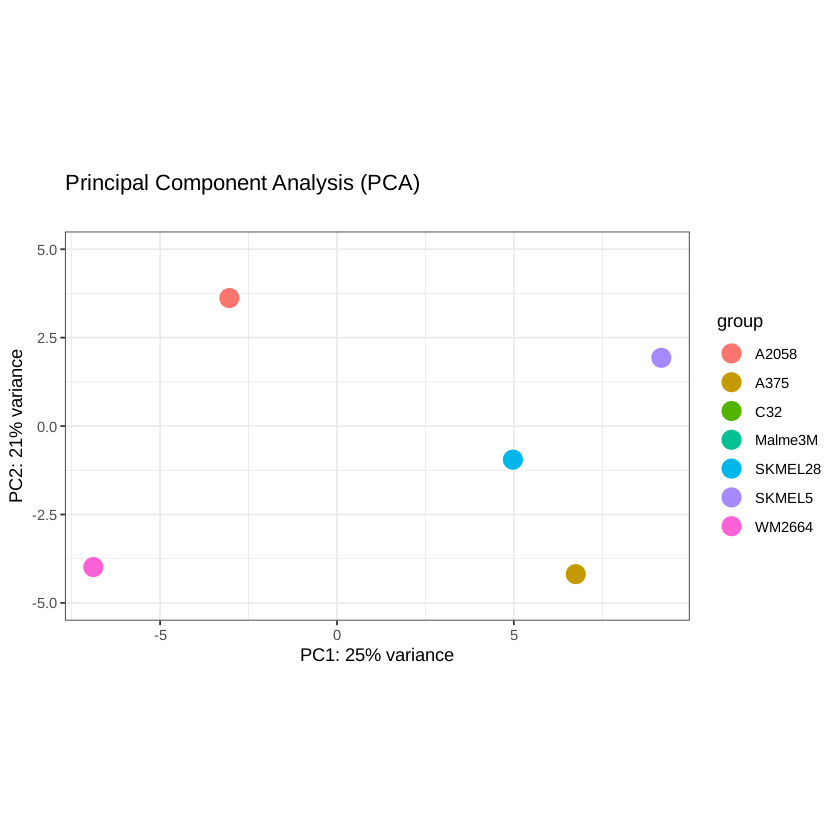

In [11]:
ddsMat_rlog <- rlog(ddsMat, blind = FALSE)
plotPCA(ddsMat_rlog, intgroup = "Group", ntop = 500) +
  theme_bw() + # remove default ggplot2 theme
  geom_point(size = 5) + # Increase point size
  scale_y_continuous(limits = c(-5, 5)) + # change limits to fix figure dimensions
  ggtitle(label = "Principal Component Analysis (PCA)", 
          subtitle = "") 

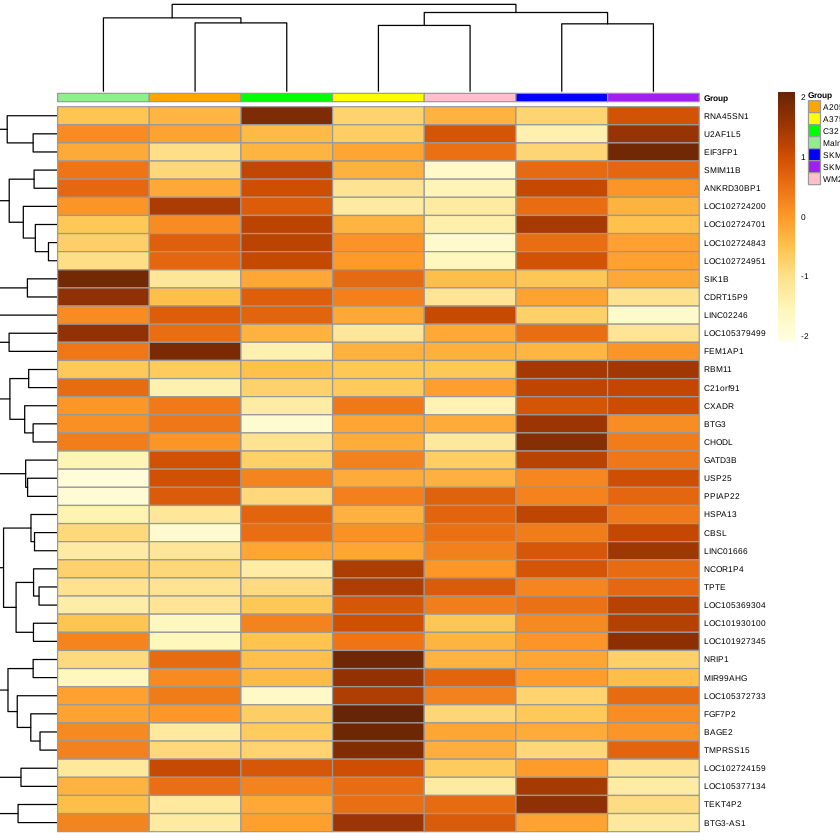

In [12]:
ddsMat_rlog <- rlog(ddsMat, blind = FALSE)
mat <- assay(ddsMat_rlog[row.names(results_sig)])[1:40, ]

##

annotation_col = data.frame(
  Group = factor(colData(ddsMat_rlog)$Group), 
  row.names = colData(ddsMat_rlog)$sampleid
)

##


ann_colors = list(
  Group = c(A2058 = "orange", A375 = "yellow", C32 = "green", Malme3M = "lightgreen", SKMEL28 = "blue", SKMEL5 = "purple", WM2664 = "pink"), 
  sampleid= c(a = "green")  
)

##

pheatmap(mat = mat, 
         color = colorRampPalette(brewer.pal(9, "YlOrBr"))(255), 
         scale = "row", # Scale genes to Z-score (how many standard deviations)
         annotation_col = annotation_col, # Add multiple annotations to the samples
         annotation_colors = ann_colors,# Change the default colors of the annotations
         fontsize = 5, # Make fonts smaller
         cellwidth = 55, # Make the cells wider
         show_colnames = F)

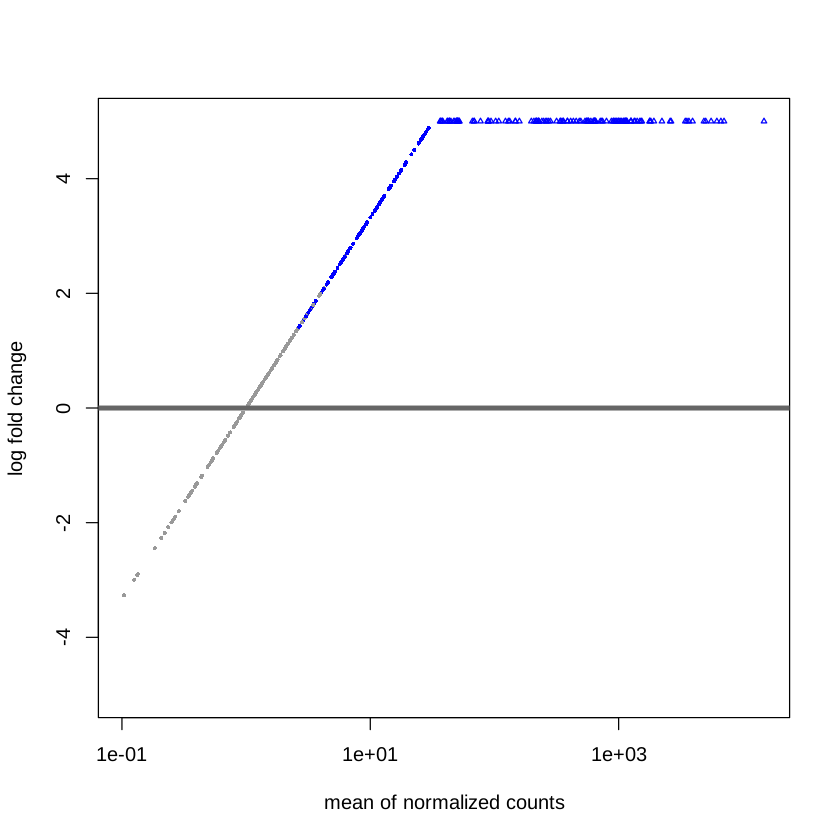

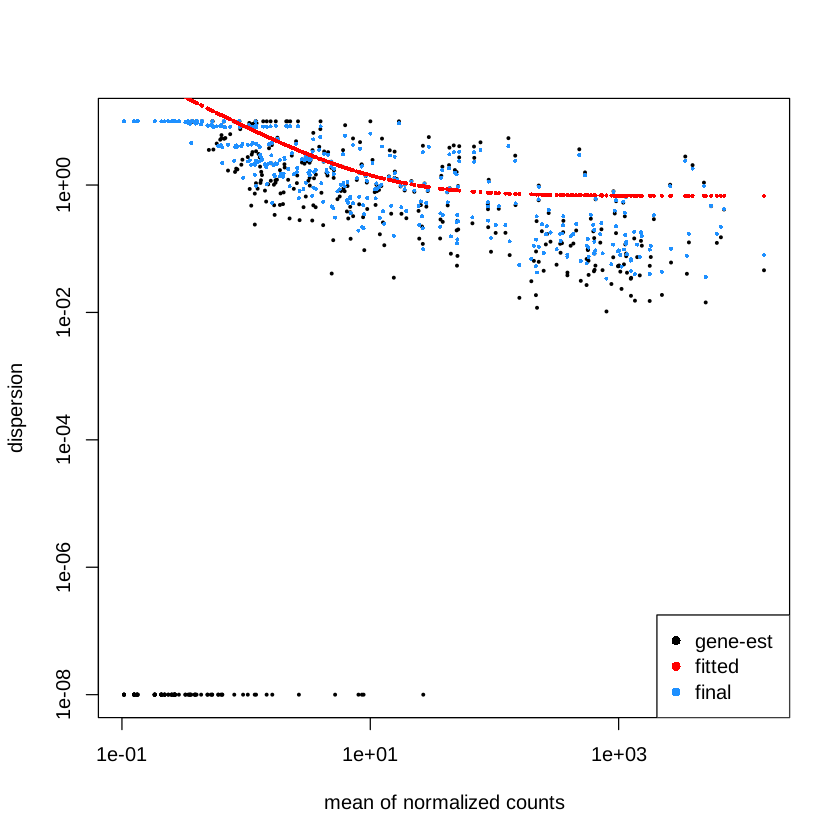

In [13]:
plotMA(results, ylim = c(-5, 5))
plotDispEsts(ddsMat)

In [14]:
results_sig_entrez <- subset(results_sig, is.na(entrez) == FALSE)

# Create a matrix of gene log2 fold changes
gene_matrix <- results_sig_entrez$log2FoldChange

# Add the entrezID's as names for each logFC entry
names(gene_matrix) <- results_sig_entrez$entrez

# View the format of the gene matrix
##- Names = ENTREZ ID
##- Values = Log2 Fold changes
head(gene_matrix)

102724023 102724159 102724200 102724428 102724701 102724560 
 5.190473  5.651311  3.024774  4.286769  5.200340  4.036168

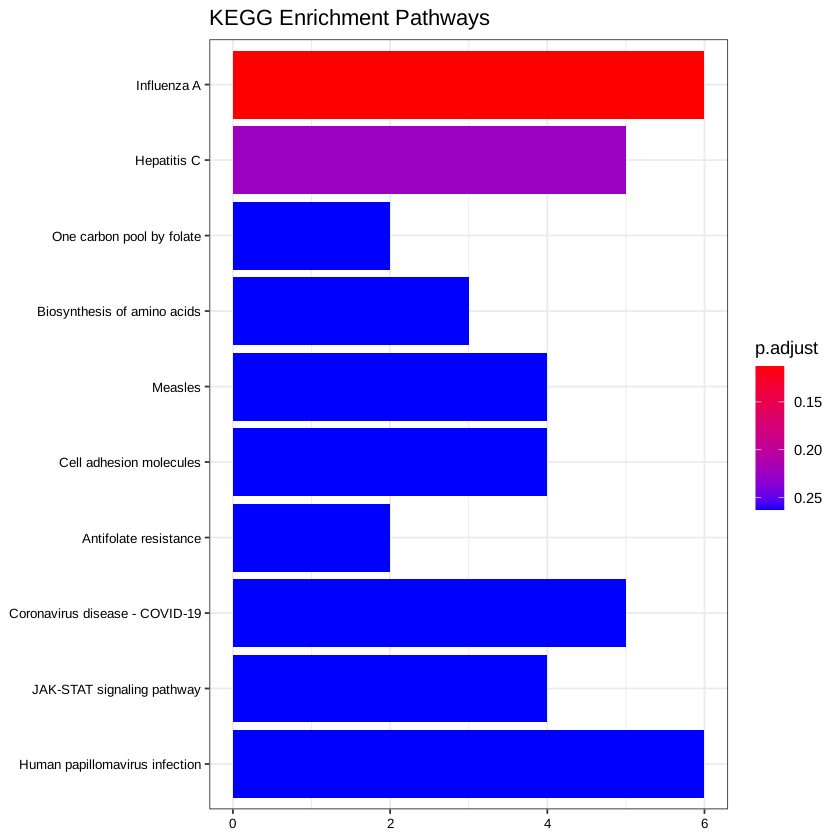

In [22]:
kegg_enrich <- enrichKEGG(gene = names(gene_matrix),
                          organism = 'human',
                          pvalueCutoff = 0.30, 
                          qvalueCutoff = 0.35)

# Plot results
barplot(kegg_enrich, 
        drop = TRUE, 
        showCategory = 10, 
        title = "KEGG Enrichment Pathways",
        font.size = 8)

In [23]:
# Load pathview
library(pathview)

# Plot specific KEGG pathways (with fold change) 
## pathway.id : KEGG pathway identifier
pathview(gene.data = gene_matrix, 
         pathway.id = "04070", 
         species = "human")

##############################################################################
Pathview is an open source software package distributed under GNU General
Public License version 3 (GPLv3). Details of GPLv3 is available at
http://www.gnu.org/licenses/gpl-3.0.html. Particullary, users are required to
formally cite the original Pathview paper (not just mention it) in publications
or products. For details, do citation("pathview") within R.

The pathview downloads and uses KEGG data. Non-academic uses may require a KEGG
license agreement (details at http://www.kegg.jp/kegg/legal.html).
##############################################################################

Info: Downloading xml files for hsa04070, 1/1 pathways..

Info: Downloading png files for hsa04070, 1/1 pathways..

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /home/fascue/Documentos/Transcriptomica/results/counts

Info: Writing image file hsa04070.pathview.png

